# Cancer Data Experimental ML Analysis v5

In [1]:
#import useful libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import sys
import umap.umap_ as umap
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.decomposition import KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold

In [187]:
def experiments_BACs(X_train, X_test, y_train, y_test, k):
    
    #CST goes here
    X_train_trans, f = CST_fit(X_train, y_train)
    X_test_trans = CST_transform(X_test, f)
    cst_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, 2)
    
    pca = PCA(n_components = k)
    pca.fit(X_train)
    X_train_trans = pca.transform(X_train)
    X_test_trans = pca.transform(X_test)
    pca_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    selectKBest = SelectKBest(score_func=mutual_info_classif, k=2)
    selectKBest.fit(X_train, y_train)
    X_train_trans = selectKBest.transform(X_train)
    X_test_trans = selectKBest.transform(X_test)
    mi_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    mapper = umap.UMAP(n_neighbors=(3)).fit(X_train, y_train)
    X_train_trans = mapper.transform(X_train)
    X_test_trans = mapper.transform(X_test)
    umap_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    kpca = KernelPCA(n_components = k, kernel = 'poly')
    kpca.fit(X_train)
    X_train_trans = kpca.transform(X_train)
    X_test_trans = kpca.transform(X_test)
    kpca_bacs = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k)
    
    return  cst_bacs, pca_bacs, mi_bacs, umap_bacs, kpca_bacs
    

In [188]:
def experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, k):
    
    temp_BACs = np.zeros(6)
    
    neighbors = KNeighborsClassifier(n_neighbors=3)
    neighbors.fit(X_train_trans, y_train)
    temp_BACs[0] = balanced_accuracy_score(y_test, neighbors.predict(X_test_trans))
    
    svm = SVC(kernel='linear', C=1)
    svm.fit(X_train_trans, y_train)
    temp_BACs[1] = balanced_accuracy_score(y_test, svm.predict(X_test_trans))
    
    gnb = GaussianNB()
    gnb.fit(X_train_trans, y_train)
    temp_BACs[2] = balanced_accuracy_score(y_test, gnb.predict(X_test_trans))
    
    rf = RandomForestClassifier(random_state=137)
    rf.fit(X_train_trans, y_train)
    temp_BACs[3] = balanced_accuracy_score(y_test, rf.predict(X_test_trans))
    
    sgd = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    sgd.fit(X_train_trans, y_train)
    temp_BACs[4] = balanced_accuracy_score(y_test, sgd.predict(X_test_trans))
    
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train_trans, y_train)
    temp_BACs[5] = balanced_accuracy_score(y_test, lda.predict(X_test_trans))
    
    return temp_BACs
    

In [189]:
#checks out bc 50 total iterations from for loops and each iteration conducts 30 ML experiments
def runexperiments_full_2(g1_samples, g2_samples):
    
    x = pd.concat([g1_samples, g2_samples]) #add together all postiive and negative labels 
    x = StandardScaler().fit_transform(x) #standardize values in x (z-score standardization)

    target_g1 = pd.DataFrame(np.zeros((len(g1_samples), 1))) #get number of target group 1
    target_g2 = pd.DataFrame(np.ones((len(g2_samples), 1))) #get number of target group 2

    target = pd.concat([target_g1, target_g2]) #concatenate target zeros ones twos etc together
    target = target.reset_index(drop=True)
    
    splits_rats = np.array([.1, .15, .2, .25, .3])

    BAC_sums_cst = np.zeros(6)
    BAC_sums_pca = np.zeros(6)
    BAC_sums_mi = np.zeros(6)
    BAC_sums_umap = np.zeros(6)
    BAC_sums_kpca = np.zeros(6)
    
    
    for i in splits_rats:
        #split the data into test and train
        X_train, X_test, y_train, y_test = train_test_split(x, target.to_numpy(), test_size=i, random_state=42)
        y_train = y_train.ravel()
        y_test = y_test.ravel()
            
        t1, t2, t3, t4, t5 = experiments_BACs(X_train, X_test, y_train, y_test, 2)
        BAC_sums_cst += t1
        BAC_sums_pca += t2
        BAC_sums_mi += t3
        BAC_sums_umap += t4
        BAC_sums_kpca += t5
    
    numIter = splits_rats.shape[0]
    BAC_sums_cst /= numIter
    BAC_sums_pca /= numIter
    BAC_sums_mi /= numIter
    BAC_sums_umap /= numIter
    BAC_sums_kpca /= numIter    
    
    return BAC_sums_cst ,BAC_sums_pca, BAC_sums_mi, BAC_sums_umap, BAC_sums_kpca
    

In [115]:
#transform X into X_trans using CST algorithm
def CST_fit(X, y):
    
    #construct upper triangular A
    sampleNum = X.shape[0] #get the number of samples
    featureNum = X.shape[1] #get the number of features
    temp_A = np.zeros((featureNum, featureNum)) #A has dimensions nxn, devised from outer product of difference of two samples's feature values
    
    #loops over SxS where S:{1,m} (m = # of samples)
    for i in range(sampleNum-1):
        #print("Progess:", i)
        start = time.time()
        for j in range(i+1, sampleNum):
            
            #I think I need a condition that says as long as i != j 
            #(actually don't because it's adding 0's, eliminating saves flops though)
            sample_difference = X[i] - X[j]
            
            #if indicator_func(y,i,j) == 1:
            if y[i] == y[j]:
                temp_A += (np.outer(sample_difference, sample_difference.T))
            else:
                temp_A -= (np.outer(sample_difference, sample_difference.T))
            
                #sample_dif_sqrd = sample_difference.reshape(-1,1) @ sample_difference.reshape(-1,1).T
                #temp_A[i][j] = indicator_func(y, i, j)*sample_dif_sqrd
                #temp_A += indicator_func(y, i, j)*sample_dif_sqrd
        end = time.time()
        #print("Time for iteration:", i, "is", end - start)
#         if i % 10 == 0:
#             print("progress at", i)
    
    #make matrix symmetric
    #A = np.where(temp_A, temp_A, temp_A.T)
    #print(temp_A) #prints the A matrix to make sure it is symmetric
    
    #calculate eigenvalues and eigenvectors of A
    eigvals, eigvecs = np.linalg.eig(temp_A)
    
    #get minimum eigenvector
    min_ind = np.argmin(eigvals)
    min_eigvec = eigvecs[:,min_ind] #in the algorithm, this is the vector f
    
    #transform the data
    X_trans = X @ min_eigvec 
    
    return np.real(X_trans).reshape(-1,1), np.real(min_eigvec)
    

In [116]:
def CST_transform(X, f):
    
    #transform the data
    X_trans = X @ f
    
    return X_trans.reshape(-1,1)
    

In [6]:
#Import experiment 1 (m v f - carcinomas)

In [144]:
df_pos1 = pd.read_csv('../preprocessedData_reduced/male_v_female_carcinomas_reduced_pos_samples.tsv', sep='\t', header=0)
df_pos1 = df_pos1.set_index(df_pos1.iloc[:,0])
df_pos1 = df_pos1.iloc[:, 1:]

df_neg1 = pd.read_csv('../preprocessedData_reduced/male_v_female_carcinomas_reduced_neg_samples.tsv', sep='\t', header=0)
df_neg1 = df_neg1.set_index(df_neg1.iloc[:,0])
df_neg1 = df_neg1.iloc[:, 1:]

In [145]:
#Import experiment 2 (m v f - adenocarcinomas)

In [146]:
df_pos2 = pd.read_csv('../preprocessedData_reduced/male_v_female_adenocarcinomas_reduced_pos_samples.tsv', sep='\t', header=0)
df_pos2 = df_pos2.set_index(df_pos2.iloc[:,0])
df_pos2 = df_pos2.iloc[:, 1:]

df_neg2 = pd.read_csv('../preprocessedData_reduced/male_v_female_adenocarcinomas_reduced_neg_samples.tsv', sep='\t', header=0)
df_neg2 = df_neg2.set_index(df_neg2.iloc[:,0])
df_neg2 = df_neg2.iloc[:, 1:]

In [147]:
#Import experiment 3 (ped v nonped - carcinomas)

In [148]:
df_pos3 = pd.read_csv('../preprocessedData_reduced/ped_v_nonped_carcinomas_reduced_pos_samples.tsv', sep='\t', header=0)
df_pos3 = df_pos3.set_index(df_pos3.iloc[:,0])
df_pos3 = df_pos3.iloc[:, 1:]

df_neg3 = pd.read_csv('../preprocessedData_reduced/ped_v_nonped_carcinomas_reduced_neg_samples.tsv', sep='\t', header=0)
df_neg3 = df_neg3.set_index(df_neg3.iloc[:,0])
df_neg3 = df_neg3.iloc[:, 1:]

In [149]:
#Import experiment 4 (ped v nonped - adenocarcinomas) # SCRAPPED

In [150]:
# df_pos4 = pd.read_csv('../preprocessedData/ped_v_nonped_adenocarcinomas_reduced_pos_samples.tsv', sep='\t', header=0)
# df_pos4 = df_pos4.set_index(df_pos4.iloc[:,0])
# df_pos4 = df_pos4.iloc[:, 1:]

# df_neg4 = pd.read_csv('../preprocessedData/ped_v_nonped_adenocarcinomas_reduced_neg_samples.tsv', sep='\t', header=0)
# df_neg4 = df_neg4.set_index(df_neg4.iloc[:,0])
# df_neg4 = df_neg4.iloc[:, 1:]

In [151]:
#Import experiment 5 (carcinomas v adenocarcinomas)

In [152]:
df_pos5 = pd.read_csv('../preprocessedData_reduced/carcinomas_v_adenocarcinomas_reduced_pos_samples.tsv', sep='\t', header=0)
df_pos5 = df_pos5.set_index(df_pos5.iloc[:,0])
df_pos5 = df_pos5.iloc[:, 1:]

df_neg5 = pd.read_csv('../preprocessedData_reduced/carcinomas_v_adenocarcinomas_reduced_neg_samples.tsv', sep='\t', header=0)
df_neg5 = df_neg5.set_index(df_neg5.iloc[:,0])
df_neg5 = df_neg5.iloc[:, 1:]

In [190]:
pos1 = df_pos1.sample(200, replace=False)
neg1 = df_neg1.sample(200, replace=False)

In [191]:
exp1_cst, exp1_pca, exp1_mi, exp1_umap, exp1_kpca = runexperiments_full_2(pos1, neg1)

In [192]:
pos2 = df_pos2.sample(200, replace=False)
neg2 = df_neg2.sample(200, replace=False)

In [193]:
exp2_cst, exp2_pca, exp2_mi, exp2_umap, exp2_kpca = runexperiments_full_2(pos2, neg2)

In [194]:
pos3 = df_pos3.sample(83, replace=False)
neg3 = df_neg3.sample(83, replace=False)

In [195]:
exp3_cst, exp3_pca, exp3_mi, exp3_umap, exp3_kpca = runexperiments_full_2(pos3, neg3)

In [196]:
pos5 = df_pos5.sample(200, replace=False)
neg5 = df_neg5.sample(200, replace=False)

In [198]:
exp5_cst, exp5_pca, exp5_mi, exp5_umap, exp5_kpca = runexperiments_full_2(pos5, neg5)

In [199]:
#method that takes in the arrays of BAC values to display

def graph_BAC_results(cstBACs, pcaBACs, miBACs, umapBACs, kpcaBACs, experiment):
    
    x = np.arange(6)
    cstBACs = np.ndarray.tolist(cstBACs)
    pcaBACs = np.ndarray.tolist(pcaBACs)
    miBACs = np.ndarray.tolist(miBACs)
    umapBACs = np.ndarray.tolist(umapBACs)
    kpcaBACs = np.ndarray.tolist(kpcaBACs)

    width = 0.86 / 6

    colors = ['#000000', '#404040', '#7f7f7f', '#bfbfbf', '#ffffff']
    DR = ['CST', 'PCA', 'MI', 'UMAP', 'kPCA']
    classifiers = ["kNN", "SVM", "GNB", "RF", "SGD", "LDA"]

    plt.figure(figsize=(15, 10))
    plt.bar(x-2*width, cstBACs, width, color='#000000', edgecolor='black')
    plt.bar(x-width, pcaBACs, width, color='#404040', edgecolor='black')
    plt.bar(x, miBACs, width, color='#7f7f7f', edgecolor='black')
    plt.bar(x+width, umapBACs, width, color='#bfbfbf', edgecolor='black')
    plt.bar(x+2*width, kpcaBACs, width, color='#ffffff', edgecolor='black')

    plt.xticks(x, classifiers)
    plt.xlabel("DR / Feature Selection")
    plt.ylabel("Balanced Accuracy scores")
    plt.legend(DR, fontsize=8)
    plt.title(experiment)
    plt.show()
    return


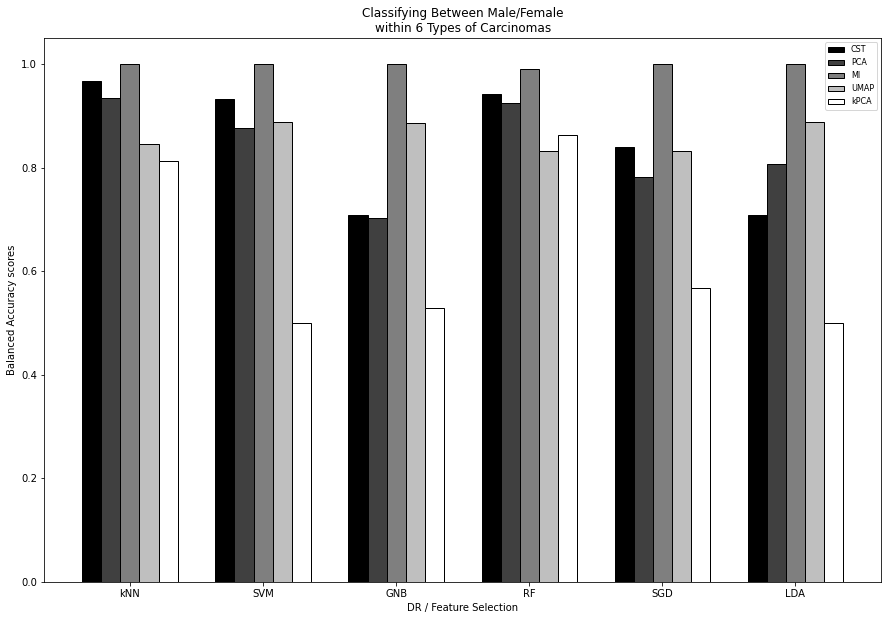

In [200]:
experiment1 = "Classifying Between Male/Female\nwithin 6 Types of Carcinomas"
graph_BAC_results(exp1_cst, exp1_pca, exp1_mi, exp1_umap, exp1_kpca, experiment1)

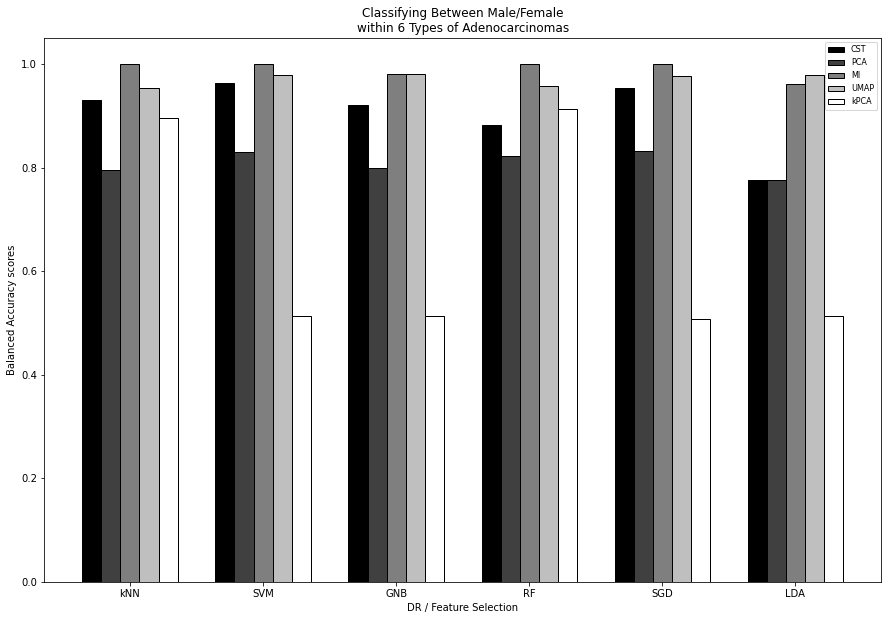

In [201]:
experiment2 = "Classifying Between Male/Female\nwithin 6 Types of Adenocarcinomas"
graph_BAC_results(exp2_cst, exp2_pca, exp2_mi, exp2_umap, exp2_kpca, experiment2)

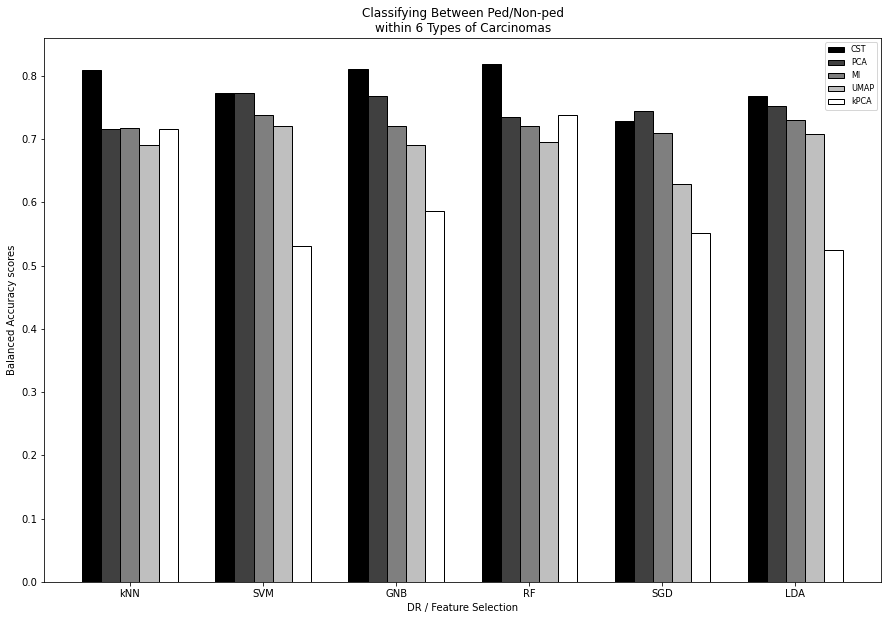

In [202]:
experiment3 = "Classifying Between Ped/Non-ped\nwithin 6 Types of Carcinomas"
graph_BAC_results(exp3_cst, exp3_pca, exp3_mi, exp3_umap, exp3_kpca, experiment3)

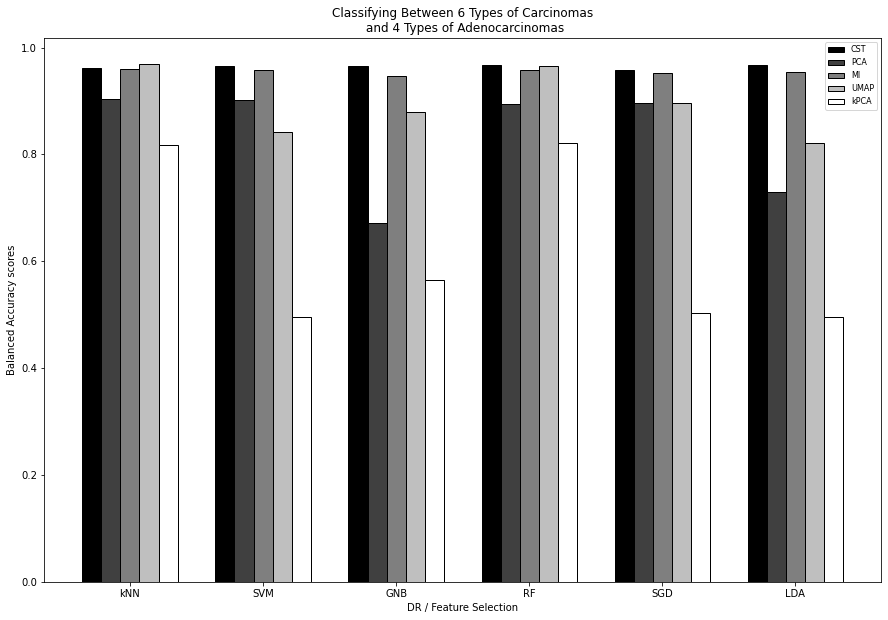

In [203]:
experiment5 = "Classifying Between 6 Types of Carcinomas\n and 4 Types of Adenocarcinomas"
graph_BAC_results(exp5_cst, exp5_pca, exp5_mi, exp5_umap, exp5_kpca, experiment5)

In [64]:
import time

In [204]:
start = time.time()
X_train_trans, f = CST_fit(X_train, y_train)
end = time.time()
print("Time to train:", end - start)

Time to train: 33.81071639060974


In [103]:
X_test_trans = CST_transform(X_test, f)

In [104]:
cst_bacs1 = experiment_BACs_helper(X_train_trans, X_test_trans, y_train, y_test, 2)

C:\Users\richi_afzmjq6\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\richi_afzmjq6\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\richi_afzmjq6\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-89-90192b15556a>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using

In [101]:
print(cst_bacs1)

[0.90740741 0.92592593 0.90740741 0.84219002 0.87037037 0.90740741]


In [45]:
x.shape

(2762, 850)

In [47]:
rand_inds = np.random.choice(x.shape)
x[0].shape

(850,)

In [30]:
x = pd.concat([df_pos2, df_neg2]) #add together all postiive and negative labels 
x = StandardScaler().fit_transform(x) #standardize values in x (z-score standardization)

target_zeros = pd.DataFrame(np.zeros((len(df_pos2), 1))) #get number of target zeros
target_ones = pd.DataFrame(np.ones((len(df_neg2), 1))) #get number of target ones
target = pd.concat([target_ones, target_zeros]) #concatenate target ones and zeros together
target = target.reset_index(drop=True)

#split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(x, target.to_numpy(), test_size=0.25, random_state=42)

In [33]:
df_pos1

,22956,22958,22959,22960,22962,22963,22964,22965,22966,22967,...,24442,24443,24444,24446,24447,24448,24449,24451,24452,24769
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-18-3407-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-18-3409-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-18-3410-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-18-3412-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-18-3414-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZF-AA4X-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-ZF-AA52-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-ZF-AA53-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
